# Following along mostly with Video

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [258]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [20]:
block_size = 3
X,Y = [], []

for w in words[:5]:
    context = [0] * 3
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[c] for c in context), "--->" ,itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [37]:
# intializing look up matrix
# 27: vocab_size, 2: num of dimensions in dense embedding matrix (or look up table)
C = torch.randn((27,2))
C.shape

torch.Size([27, 2])

In [38]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [41]:
# an alternative (more elaborative) way of indexing into embedding matrix using OneHot encodings to get embeddings
X_enc = F.one_hot(X, num_classes=27).float()
print(X_enc.shape)

(X_enc @ C).shape

torch.Size([32, 3, 27])


torch.Size([32, 3, 2])

In [59]:
# the faster way of direct indexing in PyTorch
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [60]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

# (32,6) @ (6,100) --> (32,100)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [61]:
W2 = torch.randn(100,27)
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [151]:
block_size = 3
X,Y = [], []

for w in words:
    context = [0] * 3
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[c] for c in context), "--->" ,itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [165]:
# putting together parameters init
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.numel() for p in parameters), "parameters")

for p in parameters:
    p.requires_grad = True

3481 parameters


In [160]:
for _ in range(1000):
    # get mini-batch
    ix = torch.randint(0,X.shape[0], (32,))

    # putting together the forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # probs = F.softmax(logits, dim=1)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.659186363220215


In [162]:
emb = C[X] # (32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.699045419692993

## finding appropriate stating LEARNING RATE

In [169]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
# print(sum(p.numel() for p in parameters), "parameters")

for p in parameters:
    p.requires_grad = True

for _ in range(100):
    # get mini-batch
    ix = torch.randint(0,X.shape[0], (32,))

    # putting together the forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # probs = F.softmax(logits, dim=1)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -1 * p.grad

# TRY LOOKING AT LOSS WITH DIFFERENT VALUES OF LEARNING RATE
# HERE: AT -0.001, it is barely decreasing; at -1 it is going up and down

20.389198303222656
14.332900047302246
13.261356353759766
15.806815147399902
13.663429260253906
11.264832496643066
12.92058277130127
13.578956604003906
12.999032974243164
11.629855155944824
10.483808517456055
11.123313903808594
8.655465126037598
8.421687126159668
9.327174186706543
12.72079849243164
10.092520713806152
11.234869956970215
10.284444808959961
7.396557331085205
9.010075569152832
7.734864234924316
11.210066795349121
7.763014316558838
9.492602348327637
7.7211198806762695
10.20212173461914
10.284753799438477
9.822651863098145
8.89037799835205
8.353658676147461
12.434818267822266
10.144972801208496
6.844471454620361
13.472926139831543
9.782196044921875
9.00959300994873
8.786347389221191
8.611924171447754
8.654092788696289
7.394899845123291
9.418792724609375
7.832794666290283
7.563220024108887
8.187885284423828
10.1333589553833
11.12921142578125
9.195746421813965
13.252877235412598
10.756603240966797
5.9808149337768555
8.089157104492188
6.850087642669678
9.061735153198242
8.974870

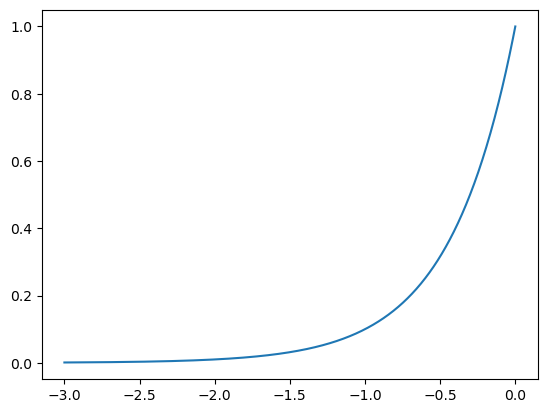

In [177]:
# looks like right lr shoulg be b/w: -1 and -0.001

lre = torch.linspace(-3, 0, 1000) # learning rate exponents
lrs = 10 ** lre
plt.plot(lre, lrs);

In [194]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.numel() for p in parameters), "parameters")

for p in parameters:
    p.requires_grad = True

3481 parameters


In [195]:
lri = []
lossi = []

for i in range(1000):
    # get mini-batch
    ix = torch.randint(0,X.shape[0], (32,))

    # putting together the forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # probs = F.softmax(logits, dim=1)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = -lrs[i]
    for p in parameters:
        p.data += lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

# TRY LOOKING AT LOSS WITH DIFFERENT VALUES OF LEARNING RATE
# HERE: AT -0.001, it is barely decreasing; at -1 it is going up and down

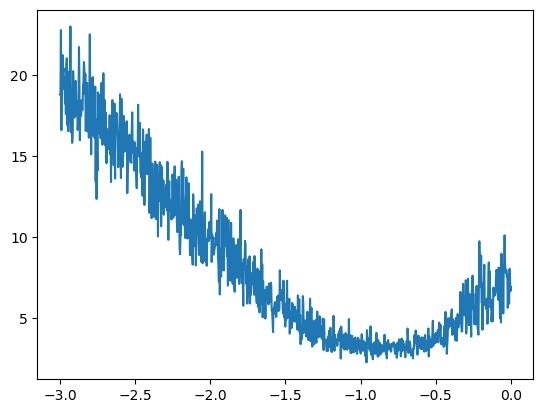

In [197]:
plt.plot(lri, lossi);

# 10** -1 looks to be a decent lr

In [199]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.numel() for p in parameters), "parameters")

for p in parameters:
    p.requires_grad = True

3481 parameters
2.411294460296631


In [200]:
for i in range(50000):
    # get mini-batch
    ix = torch.randint(0,X.shape[0], (32,))

    # putting together the forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # probs = F.softmax(logits, dim=1)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.01 * p.grad

print(loss.item())

2.225005626678467


## doing data SPLITS

In [250]:
def build_dataset(words):
    block_size = 3
    X,Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[c] for c in context), "--->" ,itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182661, 3]) torch.Size([182661])
torch.Size([22763, 3]) torch.Size([22763])
torch.Size([22722, 3]) torch.Size([22722])


In [253]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.numel() for p in parameters), "parameters")

for p in parameters:
    p.requires_grad = True

17697 parameters


In [254]:
for i in range(200000):
    # get mini-batch
    ix = torch.randint(0,Xtr.shape[0], (64,))

    # putting together the forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    # probs = F.softmax(logits, dim=1)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.0026888847351074


In [255]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1106669902801514

In [256]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.154783248901367

## sampling from the model

In [257]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dex.
mariah.
makilah.
tah.
mellissana.
nylandr.
katha.
samiyah.
javer.
giton.
moriel.
kausif.
tedo.
kaley.
masidg.
enkavirny.
fols.
milline.
vorwell.
kashru.


# Re-doing it all MYSELF

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [11]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [26]:
block_size = 3
def build_dataset(words):
    X,Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[c] for c in context), "--->", itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

# build_dataset(words[:2])

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [27]:
n_dim = 10
n_hidden = 300

In [69]:
g = torch.Generator().manual_seed(2147483647)

In [70]:
C = torch.randn((vocab_size, n_dim), generator=g)
W1 = torch.randn((block_size*n_dim, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.numel() for p in parameters), 'parameters')

17697 parameters


In [71]:
for p in parameters:
    p.requires_grad = True

In [72]:
# torch.randint(0, len(Xtr), (4,))

In [73]:
for i in range(200000):
    
    # mini-batch construct
    ix = torch.randint(0, len(Xtr), (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, block_size*n_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # zero the grads
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update
    lr = 0.01 if i < 100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.2454328536987305


In [74]:
# evaluating loss on full train set

emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size*n_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.272286891937256

In [75]:
# evaluating loss on dev set

emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_size*n_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.298978328704834

In [76]:
# C[torch.tensor(context)].shape, C[torch.tensor([context])].shape

In [77]:
# generating from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])] # 1, block_size, n_dim
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[ch] for ch in out))

carmaheque.
hevi.
kimren.
thay.
salayson.
rahnen.
den.
rha.
kaqui.
nelenia.
chaiir.
kalegg.
halm.
jorn.
quint.
sroilea.
jamii.
watelo.
dearixi.
jaceuph.
